### Preparing data

In [78]:
import pandas as pd
import numpy as np

In [4]:
# Directory in which we have saved the data
data_directory = ""

# Read data
X_df = pd.read_csv(data_directory+"BASC197_X_corr.csv")
X = X_df.to_numpy()

Y_df = pd.read_csv(data_directory+"Y.csv")
Y = Y_df.to_numpy()
Y = Y.ravel()

### **Cross-validation**


In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score


In [6]:
def cross_validation_func(model, param_grid, X, Y, masks, cv_outer):

    scores = dict()
    recall = []
    precision = []
    accuracy = []
    roc_auc = []
    best_params = []


    # Define cv splits
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
    
    i = 0

    # Complete steps
    for train_index, test_index in cv_outer.split(X, Y):
        
        X_train, X_test = X[train_index][:, masks[i]], X[test_index][:, masks[i]]

        Y_train, Y_test = Y[train_index], Y[test_index]

        # Define search
        search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=cv_inner, refit=True, verbose=10)

        search.fit(X_train, Y_train)

        Y_pred = search.predict(X_test)

        roc_auc.append(roc_auc_score(Y_test,Y_pred))
        accuracy.append(accuracy_score(Y_test, Y_pred))
        recall.append(recall_score(Y_test,Y_pred))
        precision.append(precision_score(Y_test,Y_pred,average='weighted'))
        best_params.append(search.best_params_)
        
        i+=1

    scores["roc_auc"] = roc_auc
    scores["accuracy"] = accuracy
    scores["recall"] = recall
    scores["precision"] = precision
    scores["best_params"] = best_params
    

    return scores

In [7]:
def feature_selection(X, Y, cv_outer): 
    masks = list()

    anova_k = 100
    step_features = 20

    for train_index, test_index in cv_outer.split(X, Y):
        X_train = X[train_index]
        Y_train = Y[train_index]

        anova = SelectKBest(score_func=f_classif, k=anova_k)
        X_train = anova.fit_transform(X_train,Y_train)

        mask_anova = anova.get_support()

        rfe = RFECV(estimator=SVC(kernel="linear",C=1), cv=cv_outer, step=step_features, verbose=False)
        rfe.fit(X_train, Y_train)
        
        mask_rfe = rfe.support_
        
        mask_pad = np.pad(mask_rfe, (0, len(mask_anova) - len(mask_rfe)), constant_values=False)
        combined_mask = np.logical_or(mask_anova, mask_pad)

        masks.append(combined_mask)

    return masks



### **Models**

In [8]:
# Take data to test (eliminate afterwards)
from sklearn.model_selection import train_test_split
X_example, X_test, Y_example, Y_test = train_test_split(
    X, Y, test_size=0.95, random_state=42, shuffle=True)

In [9]:
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# Features masks for SVM, LR and XGBoost for each split
masks = feature_selection(X=X_example, Y=Y_example, cv_outer=cv_outer)

In [74]:
scores_svm_df = pd.DataFrame(masks)
scores_svm_df.to_csv('masks_results.csv', index=False)

#### SVM model

In [11]:
param_grid_svm = {'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': [0.01, 1e-3, 1e-4],'C': [0.1, 10, 100, 1000]}
model_svm = SVC(probability=True, random_state=42)

scores_svm = cross_validation_func(model_svm, param_grid=param_grid_svm, X=X_example, Y=Y_example, masks=masks, cv_outer=cv_outer)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 1/5; 1/36] END C=0.1, gamma=0.01, kernel=rbf;, score=0.571 total time=   0.0s
[CV 2/5; 1/36] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 2/5; 1/36] END C=0.1, gamma=0.01, kernel=rbf;, score=0.571 total time=   0.0s
[CV 3/5; 1/36] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 3/5; 1/36] END C=0.1, gamma=0.01, kernel=rbf;, score=0.571 total time=   0.0s
[CV 4/5; 1/36] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 4/5; 1/36] END C=0.1, gamma=0.01, kernel=rbf;, score=0.429 total time=   0.0s
[CV 5/5; 1/36] START C=0.1, gamma=0.01, kernel=rbf..............................
[CV 5/5; 1/36] END C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5; 2/36] START C=0.1, gamma=0.01, kernel=poly.............................
[CV 1/5; 2/36] END C=0.1, gamma=0.01, kern

In [22]:
scores_svm_df = pd.DataFrame(scores_svm)
scores_svm_df.to_csv('svm_results.csv', index=False)

#### Logistic Regression

In [20]:
model_lr = LogisticRegression(random_state=42, solver="saga", max_iter=10000)
param_grid_lr ={"C":[0.1, 10, 100, 1000], "penalty":["l1","l2"]}

In [21]:
scores_lr = cross_validation_func(model_lr, param_grid_lr, X_example, Y_example, masks=masks, cv_outer=cv_outer)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START C=0.1, penalty=l1...........................................
[CV 1/5; 1/8] END ............C=0.1, penalty=l1;, score=0.571 total time=   0.0s
[CV 2/5; 1/8] START C=0.1, penalty=l1...........................................
[CV 2/5; 1/8] END ............C=0.1, penalty=l1;, score=0.571 total time=   0.0s
[CV 3/5; 1/8] START C=0.1, penalty=l1...........................................
[CV 3/5; 1/8] END ............C=0.1, penalty=l1;, score=0.571 total time=   0.0s
[CV 4/5; 1/8] START C=0.1, penalty=l1...........................................
[CV 4/5; 1/8] END ............C=0.1, penalty=l1;, score=0.429 total time=   0.0s
[CV 5/5; 1/8] START C=0.1, penalty=l1...........................................
[CV 5/5; 1/8] END ............C=0.1, penalty=l1;, score=0.500 total time=   0.0s
[CV 1/5; 2/8] START C=0.1, penalty=l2...........................................
[CV 1/5; 2/8] END ............C=0.1, penalty=l2;,

In [23]:
scores_lr_df = pd.DataFrame(scores_lr)
scores_lr_df.to_csv('lr_results.csv', index=False)

#### XGBoost

In [24]:
model_xgb = XGBClassifier(random_state=42)

param_grid_xgb = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }

In [25]:
scores_xgb = cross_validation_func(model_xgb, param_grid_xgb, X=X_example, Y=Y_example, masks=masks, cv_outer=cv_outer)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 1/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.571 total time=   0.3s
[CV 2/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 2/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.429 total time=   0.2s
[CV 3/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 3/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.571 total time=   0.1s
[CV 4/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 4/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.857 total time=   0

In [26]:
scores_xgb_df = pd.DataFrame(scores_xgb)
scores_xgb_df.to_csv('xgb_results.csv', index=False)

### **Analysis**


In [138]:
import matplotlib.pyplot as plt

In [56]:
scores_svm_df = pd.read_csv("svm_results.csv")
scores_lr_df = pd.read_csv("lr_results.csv")
scores_xgb_df = pd.read_csv("xgb_results.csv")

In [63]:
# Create a summary DataFrame

svm_mean = scores_svm_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(3)
lr_mean = scores_lr_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(3)
xgb_mean = scores_xgb_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(3)

summary_df = pd.DataFrame({
    'Model': ['SVM', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [svm_mean['accuracy'], lr_mean['accuracy'], xgb_mean['accuracy']],
    'Precision': [svm_mean['precision'], lr_mean['precision'], xgb_mean['precision']],
    'Recall': [svm_mean['recall'], lr_mean['recall'], xgb_mean['recall']],
    'ROC AUC': [svm_mean['roc_auc'], lr_mean['roc_auc'], xgb_mean['roc_auc']]
    
})

In [68]:
print(summary_df)

                 Model  Accuracy  Precision  Recall  ROC AUC
0                  SVM     0.492      0.497    0.53    0.490
1  Logistic Regression     0.561      0.588    0.53    0.565
2              XGBoost     0.567      0.577    0.58    0.565


In [70]:
# We look for the parameters of the best estimator
print(scores_svm_df)

   roc_auc  accuracy  recall  precision  \
0    0.575  0.555556    0.40   0.592593   
1    0.325  0.333333    0.40   0.333333   
2    0.425  0.444444    0.60   0.425926   
3    0.500  0.500000    0.50   0.500000   
4    0.625  0.625000    0.75   0.633333   

                                      best_params  
0   {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}  
1     {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}  
2       {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}  
3  {'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}  
4     {'C': 100, 'gamma': 0.01, 'kernel': 'poly'}  


In [88]:
# Best model
best_model = SVC(random_state=42, kernel="poly", C=100, gamma=0.01)

masks = pd.read_csv("masks_results.csv")

best_mask = np.array(masks.loc[0])
X_selected = X_example[:,best_mask]

X_selected.shape


(43, 180)

In [89]:
best_model.fit(X_selected, Y_example)

SVC(C=100, gamma=0.01, kernel='poly', random_state=42)

In [47]:
# We import the atlas which was originally used for computing the data

from nilearn import datasets
from nilearn import plotting

basc_197 = datasets.fetch_atlas_basc_multiscale_2015(version='sym', resolution="197")

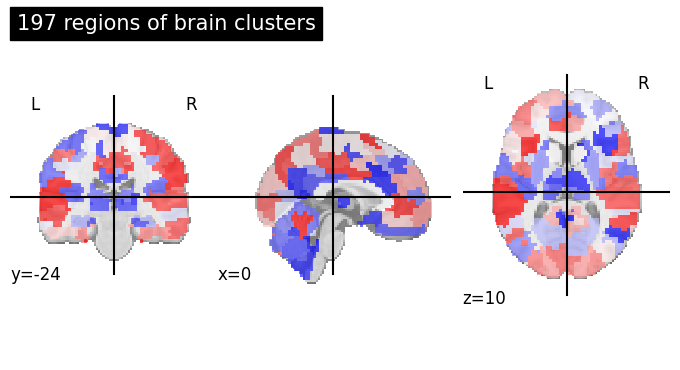

In [45]:
# Plotting the regions of interest of BASC197

plotting.plot_roi(
    basc_197["maps"], cmap=plotting.cm.bwr, title="197 regions of brain clusters"
)

plotting.show()

In [ ]:
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(basc_197["maps"],
                           memory='nilearn_cache',
                           memory_level=1,
                           smoothing_fwhm=6,
                           detrend=True,
                           verbose=1)

In [46]:
masker.fit()

report = masker.generate_report()
report

[NiftiLabelsMasker.fit] loading data from /home/juancruz/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale197.nii.gz


/home/juancruz/miniconda3/envs/neurodc/lib/python3.11/site-packages/nilearn/maskers/nifti_labels_masker.py:317: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)


label value,size (in mm^3),relative size (in %)
1,3753,0.24
2,4590,0.29
3,4752,0.3
4,3726,0.24
5,4266,0.27
6,3861,0.25
7,4482,0.29
8,3996,0.26
9,6588,0.42
10,11205,0.72


  0%|          | 0/43 [00:00<?, ?it/s]

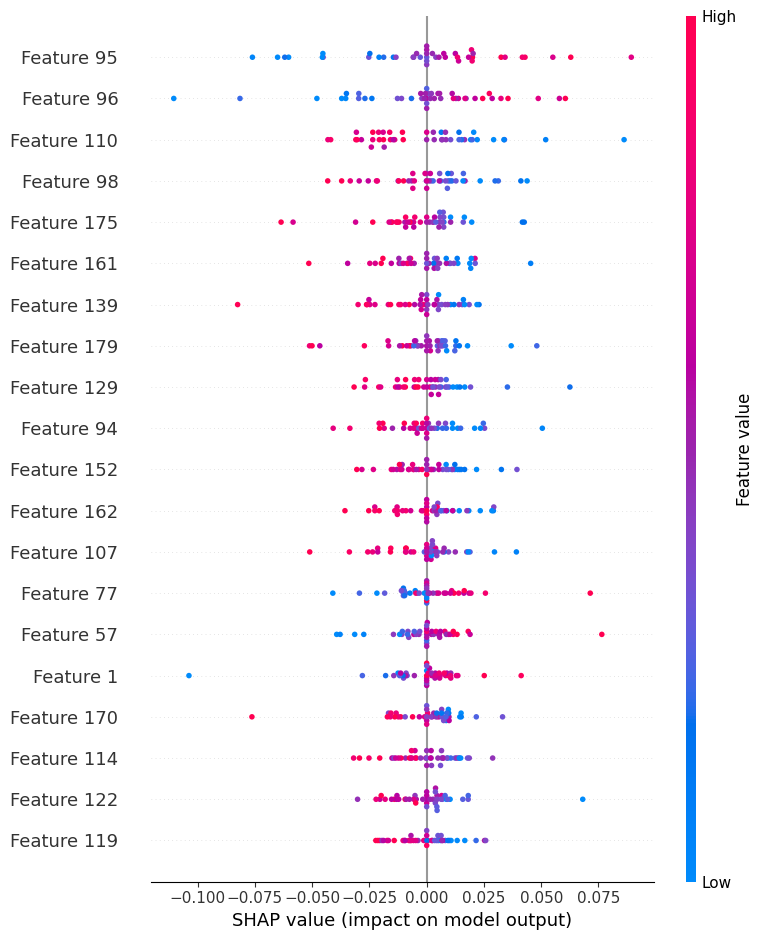

In [91]:
import shap
# Create a SHAP explainer for the model
explainer = shap.KernelExplainer(best_model.predict, X_selected)

# Calculate SHAP values
shap_values = explainer(X_selected)

# Visualize SHAP values
shap.summary_plot(shap_values, X_selected)

### Tests

In [16]:
# Convert data to one DataFrame

def to_dataframe(X,Y):
    df_features = pd.DataFrame(X)

    # Convert the n x 1 array to a DataFrame
    df_labels = pd.DataFrame(Y)

    # Assign column names to the features DataFrame
    num_features = df_features.shape[1]
    feature_columns = [f'feature{i+1}' for i in range(num_features)]
    df_features.columns = feature_columns

    # Assign a column name to the labels DataFrame
    df_labels.columns = ['label']

    # Concatenate the two DataFrames
    data_df = pd.concat([df_features, df_labels], axis=1)

    return data_df, feature_columns

data_df, feature_columns = to_dataframe(X,Y)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.95, random_state=42, shuffle=True)

In [72]:
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from julearn.viz import plot_scores
from julearn import config

data_df_test, feature_columns = to_dataframe(X_train, Y_train)

step_features = 20

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

anova_model = SelectKBest(score_func=f_classif, k=100)
rfe_model = RFECV(estimator=SVC(kernel="linear",C=1), cv=cv, step=step_features, verbose=True)


creator1 = PipelineCreator(problem_type = "classification")
creator1.add(name="anova", step=anova_model)
creator1.add(name="RFE", step=rfe_model)
creator1.add("svm", kernel="linear", C=[0.1,1])

creator2 = PipelineCreator(problem_type="classification")
creator2.add(name="anova", step=anova_model)
creator2.add(name="RFE", step=rfe_model)
creator2.add("svm", kernel=["poly", "rbf", "sigmoid"], coef0=[0.1,1,10],gamma=[0.1, 0.01, 1e-3, 1e-4])


scores, model, inspector = run_cross_validation(
    X=feature_columns,
    y="label",
    data=data_df_test,
    model=[creator1],
    cv=cv,
    return_train_score=True,
    return_inspector=True,
    verbose=100,

)



X has 19503 columns. Checking X_types for consistency might take a while. To skip this checks, set the config flag `disable_xtypes_check` to `True`.
/home/juancruz/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:465: RuntimeWarning: X has 19503 columns. Checking X_types for consistency might take a while. To skip this checks, set the config flag `disable_xtypes_check` to `True`.
  warn_with_log(
The following columns are not defined in X_types: ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15', 'feature16', 'feature17', 'feature18', 'feature19', 'feature20', 'feature21', 'feature22', 'feature23', 'feature24', 'feature25', 'feature26', 'feature27', 'feature28', 'feature29', 'feature30', 'feature31', 'feature32', 'feature33', 'feature34', 'feature35', 'feature36', 'feature37', 'feature38', 'feature39', 'feature40', 'feature41', 'f

[CV] START .....................................................................
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 100 features.
Fitting estimator with 80 features.
Fitting estimator with 60 features.
Fitting estimator with 40 features.
Fitting estimator with 20 features.
Fitting estimator with 100 features.
Fitting estim

In [58]:
scores.estimator[4].cv_results_


{'mean_fit_time': array([0.31332908, 0.28655071, 0.29349532, 0.31984296]),
 'std_fit_time': array([0.00662285, 0.0027947 , 0.01342583, 0.07450334]),
 'mean_score_time': array([0.02067142, 0.01940055, 0.0201766 , 0.01970344]),
 'std_score_time': array([0.00081804, 0.00070767, 0.0024449 , 0.00148978]),
 'param_svm__C': masked_array(data=[0.1, 1, 10, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svm__C': 0.1}, {'svm__C': 1}, {'svm__C': 10}, {'svm__C': 100}],
 'split0_test_score': array([0. , 0.5, 0.5, 0.5]),
 'split1_test_score': array([0.  , 0.25, 0.25, 0.25]),
 'split2_test_score': array([0.125, 0.625, 0.75 , 0.75 ]),
 'split3_test_score': array([0.625, 0.375, 0.5  , 0.5  ]),
 'split4_test_score': array([0.5, 0.5, 0.5, 0.5]),
 'mean_test_score': array([0.25, 0.45, 0.5 , 0.5 ]),
 'std_test_score': array([0.26220221, 0.12747549, 0.15811388, 0.15811388]),
 'rank_test_score': array([4, 3, 1, 1], dtype=int32)}